In [1]:
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
EGFP = Phasor([0.497,0.503],[2.43,3.07])

In [3]:
# tdata = np.loadtxt('EGFPt.csv')
# ydata = np.loadtxt('EGFPy2.csv')

In [4]:
# def trim_rescale_data(tdata,ydata,end =int(0.6*380),rescale = True):
#     max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
#     tdata = tdata[:end-max_idx] #start from t = 0
#     ydata = ydata[max_idx:end]  #start from max.
#     if rescale == True:
#         yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
#         ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
#     else:
#         yerr = np.sqrt(ydata)
#     weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
#     return tdata,ydata,weights

In [3]:
def trim_rescale_data(tdata,ydata,r = 10,rescale = True):
    '''Trim and rescale data (if rescale ==True)
       tdata    EGFP.t
       ydata    EGFP.y2 
       r        select points with y>r*max(y)
       rescale  True to rescale, False won't rescale'''
     #select points >r counts only
    ydata = ydata[ydata>r]
    #trim away IRF
    ydata = ydata[np.argmax(ydata):]
    #set tdata to same length, start from t = 0
    tdata = tdata[:len(ydata)]
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

def exp(t, A, tau):
    return A * np.exp(-t/tau)

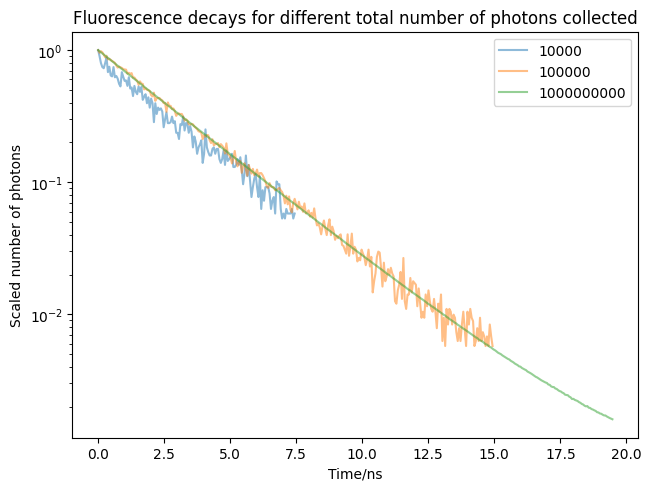

In [4]:
for n_photon in [int(1e4),int(1e5),int(1e9)]:
    EGFP.n_photon = n_photon
    EGFP.multi_exp_data()
    tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2,rescale = True)
    plt.plot(tdata,ydata,alpha = 0.5,label = str(n_photon))
plt.legend()
plt.title('Fluorescence decays for different total number of photons collected' )
plt.xlabel('Time/ns')
plt.ylabel('Scaled number of photons')
plt.yscale('log')

In [5]:
def poisson_deviance_residual(observed, expected):
    '''Return Poisson deviance residual array for given observed data and expected (model) '''
    residual=  np.sign(observed-expected)*np.sqrt(abs(2 *  (observed* np.log(observed/ expected) - (observed- expected)))) #residual array
    return residual

def residual(p, t, data):
    '''Return residual array for lmfit.minimizer to minimize in the sum of squares sense
       Inputs:
       p         lmfit.Parameters() object
       t         time array (independent variable)
       data      data array to be fitted'''
    v = p.valuesdict() #obtain dictionary of parameter values
    expected = 0
    if 'c' in v:
        expected = v['c'] #constant background
    M = 1
    while f'A{M}' in v:
        expected += exp(t, v[f'A{M}'], v[f'tau{M}']) #add exponential component
        M += 1
    return poisson_deviance_residual(data, expected) #lmfit.minimizer minimize the residual array in the sum of squared sense

def initial_params(M,A_guess,tau_guess,c_guess = 0,rescale = True,bg_removed = False):
    '''Create and return initial parameters of fit (lmfit.Parmaeters() object)
       Input:
       M          number of lifetime components
       A_guess    np.array of A1,...AM amplitudes guess
       tau_guess  np.array of tau1,...tauM lifetimes guess
       c_guess    constant background offset guess
       rescale    True if the ydata is rescaled
       bg_removed True if bg is removed
       '''
    p = lmfit.Parameters()
    if bg_removed == False:
        p.add_many(('c', c_guess, True, 0)) #constant background
    for i in range(1,M+1): #for each component
        p.add_many((f'A{i}', A_guess[i-1], True,0)) #amplitude
    for i in range(1,M+1):
        p.add_many((f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    if rescale == True:
        p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p

def chi2(params):
    '''Return chi2 from given parameters (np.array)'''
    M = int((len(params)-1)/2)
    p = initial_params(M,params[1:M+1],params[M+1:],c_guess=params[0],rescale = False)
    return np.dot(residual(p, tdata, ydata),residual(p, tdata, ydata))


### Bi-exp decay fit to EGFP

#### Rescaled data:

In [6]:
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2-EGFP.bg*EGFP.run_time/380)
p1 = initial_params(2,EGFP.amp,EGFP.tau)
p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method='powell')

print(lmfit.fit_report(mi1))


[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 196
    # data points      = 270
    # variables        = 3
    chi-square         = 0.13590739
    reduced chi-square = 5.0902e-04
    Akaike info crit   = -2044.43496
    Bayesian info crit = -2033.63970
[[Variables]]
    c:     0 (fixed)
    A1:    0.46430935 +/- 1.03932283 (223.84%) (init = 0.497)
    A2:    0.53569065 +/- 1.03932283 (194.02%) == '1 - A1'
    tau1:  2.49559473 +/- 0.55541244 (22.26%) (init = 2.43)
    tau2:  3.02403697 +/- 0.55021819 (18.19%) (init = 3.07)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, tau2)   = 0.996
    C(A1, tau1)   = 0.993
    C(tau1, tau2) = 0.978


### No rescale

Without background:

In [10]:
#generate data for a particular total collected photon number
EGFP.n_photon = int(1e5)
w,p = EGFP.multi_exp_data()

In [11]:
y_no_bg = EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins
y_with_bg = EGFP.y2
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_no_bg,rescale = False) #bg removed
p1 = initial_params(2,np.max(EGFP.y2)*EGFP.amp,EGFP.tau,rescale = False)
p1['c'].set(value = 0, vary = False)
mi2 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi2))



[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 123
    # data points      = 271
    # variables        = 4
    chi-square         = 267.400780
    reduced chi-square = 1.00150105
    Akaike info crit   = 4.37666538
    Bayesian info crit = 18.7851407
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     0 (fixed)
    A1:    941.563812 +/-        nan (nan%) (init = 947.779)
    A2:    958.664918 +/-        nan (nan%) (init = 959.221)
    tau1:  2.42993969 +/-        nan (nan%) (init = 2.43)
    tau2:  3.06484277 +/-        nan (nan%) (init = 3.07)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


In [14]:
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_with_bg,rescale = False) #bg removed
p1['c'].set(value = 0, vary = True)
mi2 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')
print(lmfit.fit_report(mi2))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 234
    # data points      = 277
    # variables        = 3
    chi-square         = 267.582800
    reduced chi-square = 0.97657956
    Akaike info crit   = -3.58100236
    Bayesian info crit = 7.29105016
[[Variables]]
    c:     2.34996917 +/- 0.71503383 (30.43%) (init = 0)
    A1:    1887.93376 +/- 9.14335654 (0.48%) (init = 1907)
    tau1:  2.75500937 +/- 0.01403324 (0.51%) (init = 2.43)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, tau1)  = -0.736
    C(A1, tau1) = -0.710
    C(c, A1)    = 0.339


### Mono-exp decay fit to EGFP

In [13]:
p1 = initial_params(1,[np.max(ydata)],EGFP.tau,rescale = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')
print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 234
    # data points      = 277
    # variables        = 3
    chi-square         = 267.582800
    reduced chi-square = 0.97657956
    Akaike info crit   = -3.58100236
    Bayesian info crit = 7.29105016
[[Variables]]
    c:     2.34996917 +/- 0.71503383 (30.43%) (init = 0)
    A1:    1887.93376 +/- 9.14335654 (0.48%) (init = 1907)
    tau1:  2.75500937 +/- 0.01403324 (0.51%) (init = 2.43)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, tau1)  = -0.736
    C(A1, tau1) = -0.710
    C(c, A1)    = 0.339


### Triple-exp fit

In [15]:

p1 = initial_params(3,[np.max(EGFP.y2*0.49),np.max(EGFP.y2)*0.51,100],EGFP.tau+[10],rescale = False)
mi3 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi3))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 480
    # data points      = 277
    # variables        = 7
    chi-square         = 267.365660
    reduced chi-square = 0.99024319
    Akaike info crit   = 4.19412520
    Bayesian info crit = 29.5622477
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     1.43713071 +/- 1.53263194 (106.65%) (init = 0)
    A1:    957.263091 +/- 399.959329 (41.78%) (init = 934.43)
    A2:    920.916798 +/- 420.023752 (45.61%) (init = 972.57)
    A3:    15.3096080 +/-        nan (nan%) (init = 100)
    tau1:  2.54684187 +/- 0.23264192 (9.13%) (init = 2.43)
    tau2:  2.98687095 +/- 0.24222312 (8.11%) (init = 3.07)
    tau3:  1.82686752 +/- 0.81294874 (44.50%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau1, tau3) = -1.425
    C(A1, tau3)   = 1.139
    C(tau2, tau3) = 1.101
    C(A1, A2)     = -1.020
    C(c, tau2)    = -0.803
    C(c, tau1)    = 0.728
    C(tau1, tau2) = -0.631

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


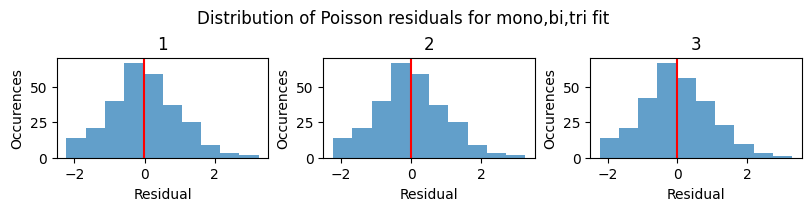

In [16]:
fig,ax = plt.subplots(ncols=3,figsize = (8,2))
fig.suptitle('Distribution of Poisson residuals for mono,bi,tri fit ')
for i in range(3):
    mi = [mi1,mi2,mi3][i]
    resid = residual(mi.params,tdata,ydata)
    ax[i].hist(resid,alpha = 0.7)
    ax[i].axvline(np.mean(residual(mi.params,tdata,ydata)),c='r',label = 'mean')
    ax[i].set_title(range(1,4)[i])
    ax[i].set_xlabel('Residual')
    ax[i].set_ylabel('Occurences')


## Get 100 simulation at each point (bi-exp decay)


In [15]:
def MLEfit(N,tdata,ydata,method ='powell',r=10,rescale=False):

    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)
MLEfit(2,EGFP.t,EGFP.sim_data[2])

,c,A1,A2,tau1,tau2
0,31.050835,0.489624,0.510376,2.420671,3.066687


In [51]:
def MLEfit(N,tdata,ydata,method ='powell',r=10,rescale=False,bg=True):
    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r, rescale=rescale)
    p1 = initial_params(N, np.max(ydata)*EGFP.amp, EGFP.tau, rescale=rescale)
    if bg == False: #background removed
      p1['c'].set(value = 0,vary = False)

    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)

def val_df(N,method='powell',sim_data=EGFP.sim_data,r=10,rescale=False,bg=True):
  '''Create dataframe of fitted parameters for 100 simulations'''
  df_list = []
  for j in range(100):
    df_list.append( MLEfit(N,EGFP.t,sim_data[j],method='powell',r=r,rescale=rescale,bg=bg))
    df= pd.concat(df_list).reset_index()
  return df.drop(['index'],axis =1)

#this would take 10 mins to run
# N=2 #components
# EGFP.y_list = np.zeros((20,100,380))
# EGFP.y_no_bg_list = np.zeros((20,100,380))
n_photon_arr = np.logspace(4,9,20)
# df_list = []
# for i in range(len(n_photon_arr)):
#   EGFP.n_photon = n_photon_arr[i]
#   EGFP.repeat_sim(100)
#   EGFP.y_list[i] = EGFP.sim_data
#   EGFP.y_no_bg_list[i] = EGFP.sim_data-EGFP.bg*EGFP.run_time/EGFP.n_bins
#   df =val_df(2)
#   df_no_bg = val_df(2,sim_data=EGFP.y_no_bg_list[i],bg=False)
#   df_rescale= val_df(2,sim_data=EGFP.y_list[i],rescale = True)
#   df_no_bg_rescale= val_df(2,sim_data=EGFP.y_no_bg_list[i],r=30,rescale = True,bg=False)
#   df_list.append([df,df_no_bg,df_rescale,df_no_bg_rescale])


In [62]:
# df_list_case = []
# for df in df_list:
#     n_val_df =pd.concat(df,keys = ['bg','no_bg','bg_rescale','no_bg_rescale'],axis = 1) #concat dfs of 4 cases along axis 1
#     df_list_case.append(n_val_df) #append each photon number case
#mle_val_df = pd.concat(df_list_case,keys = range(20))

In [63]:
#mle_val_df = pd.concat(df_list_case,keys = range(20))

In [18]:
#mle_val_df.to_csv('df/mle_val_df.csv')
mle_val_df = pd.read_csv('df/mle_val_df.csv',header=[0, 1], index_col=[0,1]) #read multi-level csv

In [19]:
idx = pd.IndexSlice #extract df using pd.IndexSlice 
#idx[n_photon_row,simulation_row]
#idx[case_col,par_col]
mle_val_df.loc(axis=1)[idx['bg',:]]  #get bg dataframe

bg                                        
              c        A1        A2      tau1      tau2
0  0   1.520828  0.475042  0.524958  2.331192  3.055875
   1   1.010585  0.476425  0.523575  2.421722  3.042954
   2   1.208356  0.497661  0.502339  2.365740  3.041872
   3   2.503252  0.478737  0.521263  2.389746  2.996661
   4   1.751802  0.475386  0.524614  2.342392  3.044150
...         ...       ...       ...       ...       ...
19 95  1.039795  0.492333  0.507667  2.409350  3.042638
   96  3.305873  0.430188  0.569812  2.689354  2.694973
   97  1.714816  0.504510  0.495490  2.423072  3.063486
   98  1.814088  0.472530  0.527470  2.731031  2.734975
   99  0.229210  0.470592  0.529408  2.386406  3.062178

[2000 rows x 5 columns]

In [37]:
np.unique(mle_val_df[mle_val_df>10])

array([1.03018845e+01, 1.08369442e+02, 1.66868638e+02, 3.41763815e+02,
       5.83127247e+07, 6.30284499e+07, 1.32784257e+10, 1.32867060e+10,
       1.36449543e+10, 2.61733870e+10, 2.81522625e+10, 3.57177745e+10,
       4.34557764e+10, 4.76127436e+10, 5.54121696e+10, 5.82228906e+10,
       1.11079307e+11, 1.35664680e+11, 1.47147716e+11, 1.62303330e+11,
       1.72960577e+11, 2.22721879e+11, 4.88622590e+11, 5.03249591e+11,
       1.30973445e+12, 2.64801468e+13, 3.44860411e+14, 3.94339050e+14,
       9.99139246e+14,            nan])

In [44]:
new_df = mle_val_df.drop(mle_val_df[mle_val_df.no_bg_rescale.tau2>10].index) #drop rows where tau2 is anamolous
new_df.dropna(inplace = True) #new df without anamolous values

In [45]:
new_df

bg                                         no_bg            \
              c        A1        A2      tau1      tau2     c        A1   
0  0   1.520828  0.475042  0.524958  2.331192  3.055875     0  0.484178   
   1   1.010585  0.476425  0.523575  2.421722  3.042954     0  0.493112   
   2   1.208356  0.497661  0.502339  2.365740  3.041872     0  0.488210   
   3   2.503252  0.478737  0.521263  2.389746  2.996661     0  0.523433   
   5   1.843776  0.473586  0.526414  2.444557  3.025324     0  0.435682   
...         ...       ...       ...       ...       ...   ...       ...   
19 95  1.039795  0.492333  0.507667  2.409350  3.042638     0  0.496964   
   96  3.305873  0.430188  0.569812  2.689354  2.694973     0  0.497028   
   97  1.714816  0.504510  0.495490  2.423072  3.063486     0  0.496921   
   98  1.814088  0.472530  0.527470  2.731031  2.734975     0  0.497048   
   99  0.229210  0.470592  0.529408  2.386406  3.062178     0  0.496864   

                                    bg_rescale                                \
             A2      tau1      tau2          c        A1        A2      tau1   
0  0   0.515822  2.403988  3.058503   0.000107  0.621722  0.378278  2.249025   
   1   0.506888  2.035892  3.335473   0.000003  0.686430  0.313570  1.861780   
   2   0.511790  2.439641  3.092342   0.014798  0.638612  0.361388  2.351452   
   3   0.476567  2.072339  3.555888   0.000339  0.286101  0.713899  1.327882   
   5   0.564318  1.999802  3.369033   0.000589  0.149857  0.850143  0.302076   
...         ...       ...       ...        ...       ...       ...       ...   
19 95  0.503036  2.430008  3.069965   0.000545  0.500040  0.499960  2.425324   
   96  0.502972  2.428959  3.070681   0.000549  0.500291  0.499709  2.425649   
   97  0.503079  2.430468  3.069527   0.000546  0.500094  0.499906  2.425644   
   98  0.502952  2.430636  3.069578   0.000553  0.498043  0.501957  2.428769   
   99  0.503136  2.430534  3.069604   0.000546  0.499770  0.500230  2.425852   

                no_bg_rescale                                          
           tau2             c        A1        A2      tau1      tau2  
0  0   3.442096             0  0.599090  0.400910  1.955791  4.195378  
   1   4.185271             0  0.840437  0.159563  1.924294  9.192933  
   2   3.003948             0  0.501843  0.498157  2.430606  3.068550  
   3   3.182602             0  0.702298  0.297702  1.901583  5.091081  
   5   2.893082             0  0.710172  0.289828  1.550557  7.321492  
...         ...           ...       ...       ...       ...       ...  
19 95  3.076437             0  0.497136  0.502864  2.429714  3.070204  
   96  3.076062             0  0.497737  0.502263  2.429166  3.071246  
   97  3.076027             0  0.497275  0.502725  2.429971  3.070020  
   98  3.071695             0  0.495814  0.504186  2.431774  3.067947  
   99  3.075734             0  0.497030  0.502970  2.429998  3.069998  

[1974 rows x 20 columns]

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_1061/2871962986.py:21: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(top=0.85)


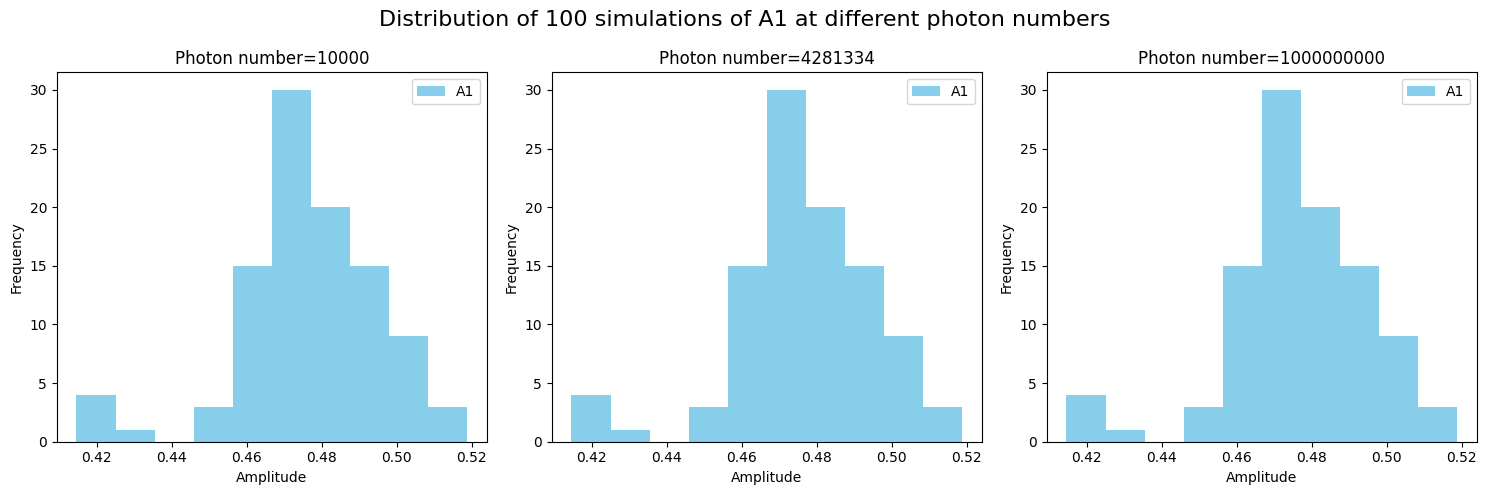

In [46]:
# Setup for loop parameters
indices = [0, 10, 19]  # Indices for low, middle, high photon number
titles = ['Photon number=10000', 'Photon number=4281334', 'Photon number=1000000000']
colors = ['skyblue', 'skyblue', 'skyblue']  # Using the same color, but allows customization
bins = 10  # Assuming you want the same number of bins for each histogram

# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, (index, title) in enumerate(zip(indices, titles)):
    axs[i].hist(mle_val_df.loc[idx[index,:], idx['bg','A1']], bins=bins, color=colors[i])
    axs[i].set_xlabel('Amplitude')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(title)
    axs[i].legend(['A1'])

# Add a main title for the plots
fig.suptitle('Distribution of 100 simulations of A1 at different photon numbers', fontsize=16)

# Adjust layout to prevent overlapping
plt.subplots_adjust(top=0.85)

plt.tight_layout()
plt.show()


In [47]:
mean_df = new_df.groupby(level=0).mean()
std_df = new_df.groupby(level=0).std()

In [48]:
mean_df

bg                                         no_bg            \
           c        A1        A2      tau1      tau2     c        A1   
0   1.600259  0.475832  0.524168  2.438445  2.988973   0.0  0.488293   
1   1.545247  0.477369  0.522631  2.432585  2.997580   0.0  0.486742   
2   1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.491239   
3   1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.492974   
4   1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.494232   
5   1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.495943   
6   1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.496901   
7   1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.496454   
8   1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.496779   
9   1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.497367   
10  1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.497056   
11  1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.496948   
12  1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.496916   
13  1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.497003   
14  1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.497034   
15  1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.496976   
16  1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.497040   
17  1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.497021   
18  1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.496994   
19  1.542191  0.477021  0.522979  2.431043  2.998454   0.0  0.496994   

                                 bg_rescale                                \
          A2      tau1      tau2          c        A1        A2      tau1   
0   0.511707  2.244066  3.296238   0.003656  0.462925  0.537075  1.625655   
1   0.513258  2.261417  3.216386   0.001567  0.563121  0.436879  1.938554   
2   0.508761  2.317347  3.162263   0.001033  0.567371  0.432629  2.173889   
3   0.507026  2.373389  3.117491   0.000888  0.504197  0.495803  2.261049   
4   0.505768  2.388525  3.099793   0.000677  0.501991  0.498009  2.318886   
5   0.504057  2.404860  3.091066   0.000650  0.498618  0.501382  2.414807   
6   0.503099  2.418662  3.079092   0.000612  0.489341  0.510659  2.448189   
7   0.503546  2.427964  3.070605   0.000536  0.502290  0.497710  2.424961   
8   0.503221  2.432466  3.067899   0.000552  0.496494  0.503506  2.433621   
9   0.502633  2.428608  3.071565   0.000556  0.494157  0.505843  2.432612   
10  0.502944  2.431568  3.069036   0.000551  0.495636  0.504364  2.430985   
11  0.503052  2.430034  3.069789   0.000545  0.499683  0.500317  2.426283   
12  0.503084  2.430379  3.069606   0.000547  0.499222  0.500778  2.426065   
13  0.502997  2.430147  3.069851   0.000547  0.499222  0.500778  2.425873   
14  0.502966  2.430105  3.069943   0.000549  0.499243  0.500757  2.426880   
15  0.503024  2.429998  3.070026   0.000549  0.499619  0.500381  2.426362   
16  0.502960  2.429999  3.070053   0.000550  0.499323  0.500677  2.427011   
17  0.502979  2.430045  3.070000   0.000549  0.499282  0.500718  2.426582   
18  0.503006  2.429979  3.069979   0.000548  0.499853  0.500147  2.425983   
19  0.503006  2.430021  3.069982   0.000548  0.499742  0.500258  2.426080   

             no_bg_rescale                                          
        tau2             c        A1        A2      tau1      tau2  
0   3.445469           0.0  0.661790  0.338210  1.886996  5.510667  
1   3.538168           0.0  0.645578  0.354422  2.033025  4.215294  
2   3.362094           0.0  0.579371  0.420629  2.124181  3.514780  
3   3.152408           0.0  0.555585  0.444415  2.313455  3.293131  
4   3.102906           0.0  0.509597  0.490403  2.240550  3.162756  
5   3.081437           0.0  0.520405  0.479595  2.396075  3.136017  
6   3.059756           0.0  0.502190  0.497810  2.425928  3.084996  
7   3.081355           0.0  0.502432  0.497568  2.422871  3.082303  
8   3.070340           0.0  0.496586  0.

In [49]:
std_df

bg                                         no_bg            \
           c        A1        A2      tau1      tau2     c        A1   
0   0.727051  0.019950  0.019950  0.125356  0.119647   0.0  0.032632   
1   0.723141  0.019292  0.019292  0.122256  0.112508   0.0  0.025479   
2   0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.020062   
3   0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.012006   
4   0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.009319   
5   0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.007155   
6   0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.005464   
7   0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.003408   
8   0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.002815   
9   0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.002207   
10  0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.001598   
11  0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.001154   
12  0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.000884   
13  0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.000569   
14  0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.000495   
15  0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.000392   
16  0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.000285   
17  0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.000201   
18  0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.000135   
19  0.718968  0.019277  0.019277  0.121592  0.111536   0.0  0.000105   

                                 bg_rescale                                \
          A2      tau1      tau2          c        A1        A2      tau1   
0   0.032632  0.220350  0.238000   0.006212  0.218549  0.218549  0.757345   
1   0.025479  0.171635  0.151210   0.002852  0.199441  0.199441  0.675016   
2   0.020062  0.116669  0.093492   0.001483  0.147807  0.147807  0.467824   
3   0.012006  0.085524  0.063548   0.000858  0.132070  0.132070  0.493304   
4   0.009319  0.053023  0.039284   0.000617  0.097839  0.097839  0.433985   
5   0.007155  0.039047  0.028896   0.000365  0.081139  0.081139  0.178247   
6   0.005464  0.028499  0.021714   0.000179  0.069486  0.069486  0.100582   
7   0.003408  0.018446  0.013496   0.000104  0.032965  0.032965  0.049067   
8   0.002815  0.018054  0.013091   0.000102  0.031639  0.031639  0.049308   
9   0.002207  0.010379  0.007830   0.000074  0.024310  0.024310  0.035388   
10  0.001598  0.009047  0.006555   0.000057  0.017748  0.017748  0.027708   
11  0.001154  0.005734  0.003906   0.000045  0.012268  0.012268  0.019660   
12  0.000884  0.004693  0.003441   0.000029  0.009374  0.009374  0.013922   
13  0.000569  0.003749  0.002709   0.000023  0.006313  0.006313  0.010298   
14  0.000495  0.002719  0.002079   0.000018  0.004467  0.004467  0.007500   
15  0.000392  0.001896  0.001453   0.000013  0.003668  0.003668  0.005842   
16  0.000285  0.001360  0.000963   0.000009  0.002830  0.002830  0.004615   
17  0.000201  0.001075  0.000837   0.000006  0.001777  0.001777  0.002899   
18  0.000135  0.000755  0.000602   0.000005  0.001372  0.001372  0.002238   
19  0.000105  0.000537  0.000394   0.000004  0.001077  0.001077  0.001548   

             no_bg_rescale                                          
        tau2             c        A1        A2      tau1      tau2  
0   0.611789           0.0  0.112334  0.112334  0.225455  1.588030  
1   0.556149           0.0  0.138586  0.138586  0.403171  0.878709  
2   0.381269           0.0  0.139239  0.139239  0.493711  0.396957  
3   0.232283           0.0  0.099384  0.099384  0.252194  0.248593  
4   0.198016           0.0  0.132808  0.132808  0.558806  0.197647  
5   0.155692           0.0  0.055903  0.055903  0.093952  0.116726  
6   0.109678           0.0  0.037535  0.037535  0.062658  0.069675  
7   0.063096           0.0  0.024930  0.024930  0.037271  0.042999  
8   0.062395           0.0  0.022517  0.

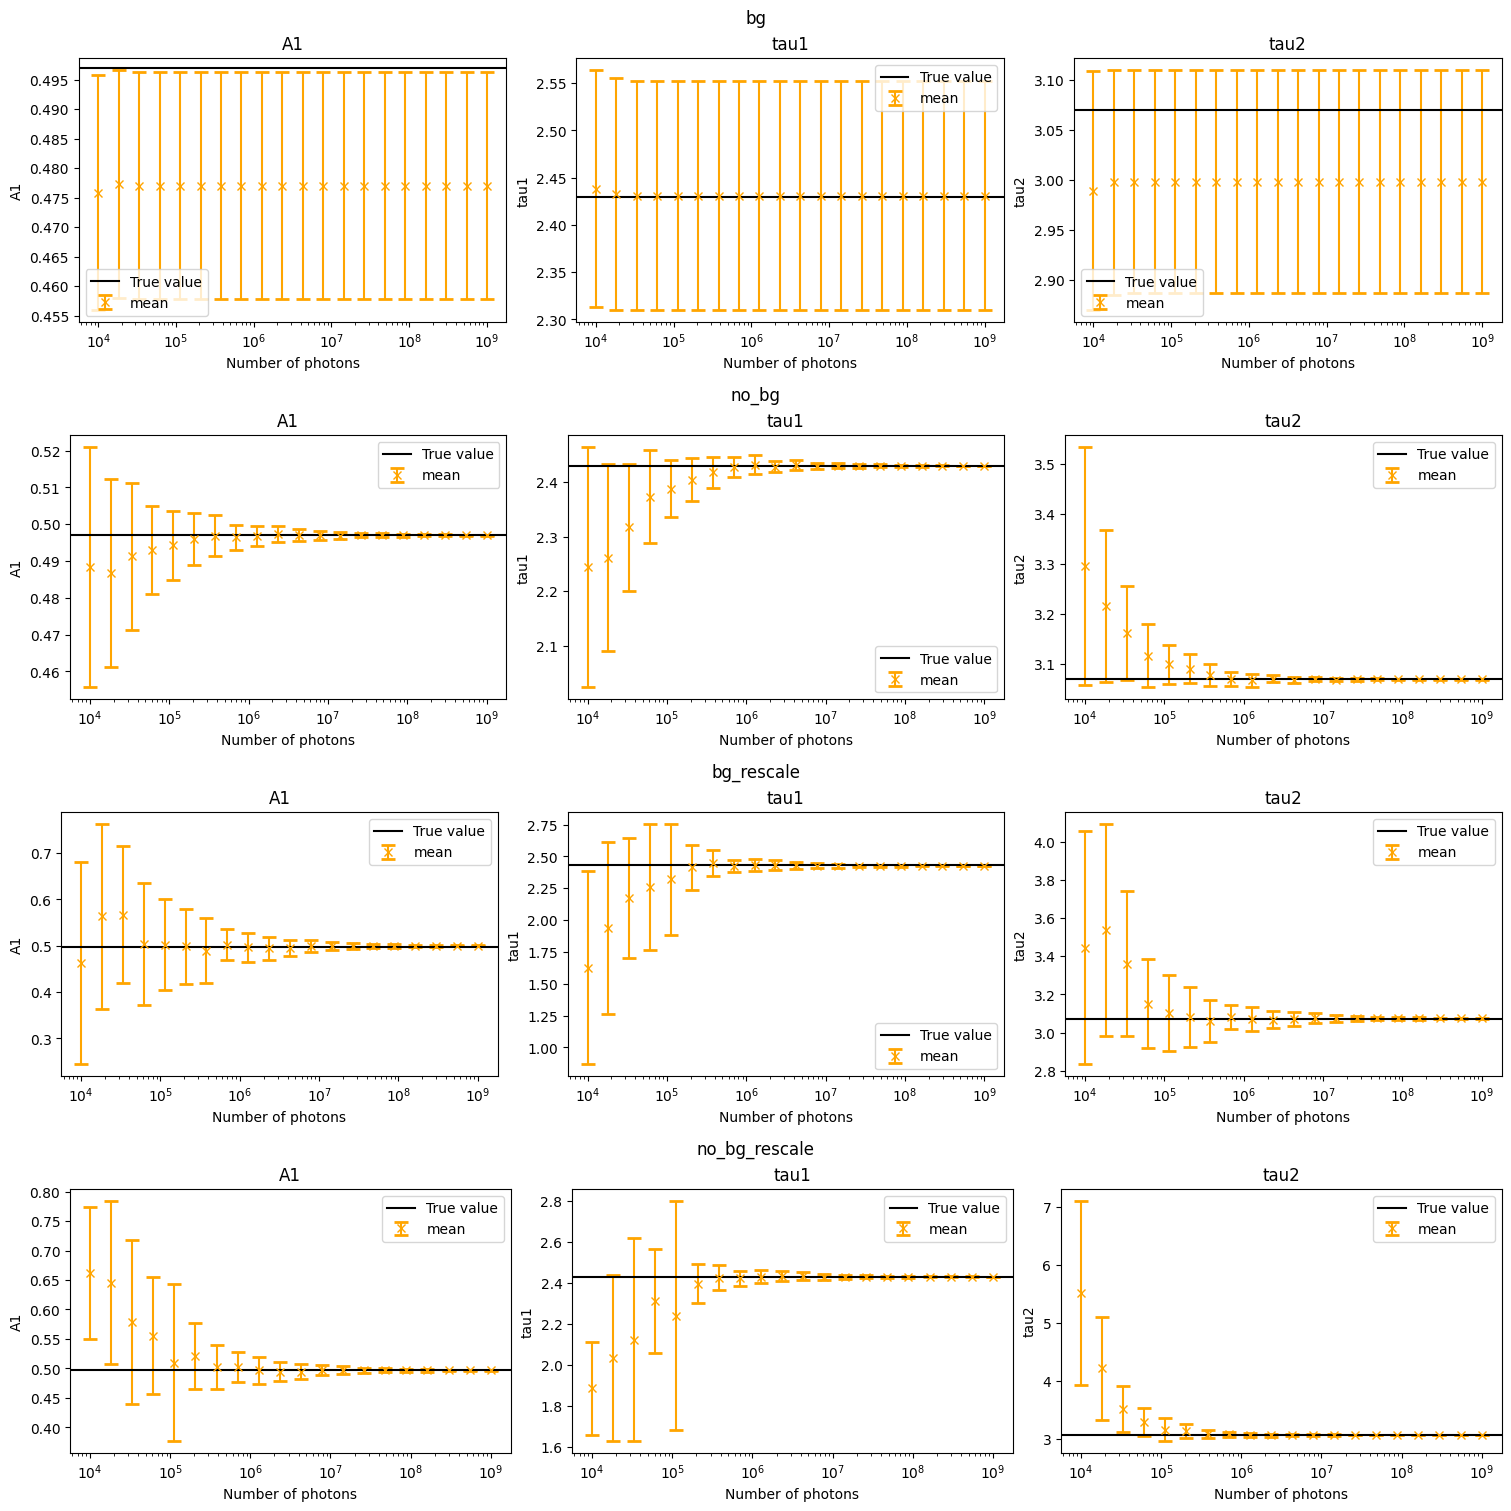

In [65]:
# Set up the subplots
fig = plt.figure( figsize=(15, 15))
big_axs = fig.subfigures(4,1)
true = [0.497,2.43,3.07]

cases = ['bg','no_bg','bg_rescale','no_bg_rescale']
for j in range(4):
    case = cases[j]
    big_axs[j].suptitle(case)
    for i in range(3):
        axs = big_axs[j].add_subplot(1, 3,i+1 )
        col = ['A1','tau1','tau2'][i] #column name
        axs.errorbar(n_photon_arr, mean_df[(case,col)], yerr=std_df[(case,col)], fmt='x', ecolor='orange', capthick=2,
                        capsize=5, color='orange', label='mean')
        axs.axhline(y=true[i], color='k', linestyle='-', label='True value')
        axs.set_xscale('log')
        axs.set_xlabel('Number of photons')
        axs.set_ylabel(col)
        axs.set_title(col)
        axs.legend()


# Show the plot
plt.show()


In [66]:
fig.savefig('fig/mle_cases_deviation.pdf')

In [ ]:
par_dict = {k:v.value for k,v in mi1.params.items()}
A_sum = sum([par_dict[f'A{j}'] for j in range(1,N+1)])
for i in range(1,N+1):
  par_dict[f'A{i}']=par_dict[f'A{i}']/A_sum

In [ ]:
par_dict

{'c': 2.6261220976405935,
 'A1': 0.4119245809129398,
 'A2': 0.5880754190870602,
 'A3': 27.31554596339662,
 'tau1': 2.0589761595478713,
 'tau2': 3.1826795650414406,
 'tau3': 8.088133811301468e-05}

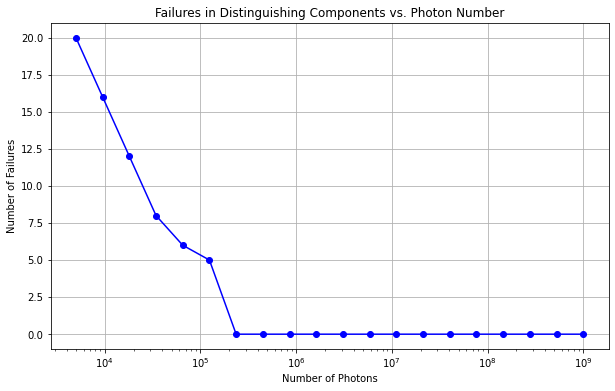

In [ ]:
# Reset failure_counts to ensure clean start
failure_counts = []

# Assuming n_photon_arr is defined and correctly populated
for n_photon in n_photon_arr:
    failures = 0
    for j in range(100):  # For each simulation
        EGFP.n_photon = n_photon
        EGFP.repeat_sim(100)
        # Assuming the simulation data EGFP.sim_data[j] is correctly populated
        # and MLEfit function works as expected
        fit_results_df = MLEfit(2, EGFP.t, EGFP.sim_data[j], method='powell', end=100, rescale=False)
        
        # Extract fitted values
        A1 = fit_results_df['A1'].iloc[0]
        A2 = fit_results_df['A2'].iloc[0]
        tau1 = fit_results_df['tau1'].iloc[0]
        tau2 = fit_results_df['tau2'].iloc[0]

        # Failure condition
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            failures += 1
    
    failure_counts.append(failures)

# Plotting the number of failures vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Failures in Distinguishing Components vs. Photon Number')
plt.grid(True)
plt.show()


In [ ]:
# Assuming n_photon_arr is defined and correctly populated
chi2_failure_counts = []

for n_photon in n_photon_arr:
    chi2_failures = 0
    EGFP.n_photon = n_photon
    EGFP.repeat_sim(100)  # Generate simulation data
    for j in range(100):  # For each simulation    
        # Perform the chi-squared fit using the predefined method
        EGFP.fit(exp2, method='leastsq',end = np.where(EGFP.y2<10)[0])
        
        # Extract fitted values directly from EGFP.par
        A1 = EGFP.par['A1'].value
        A2 = EGFP.par['A2'].value
        tau1 = EGFP.par['tau1'].value
        tau2 = EGFP.par['tau2'].value

        # Check for failure conditions similar to the MLE method
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            chi2_failures += 1

    chi2_failure_counts.append(chi2_failures)

# Plotting the number of failures for the chi-squared fit vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, chi2_failure_counts, marker='o', linestyle='-', color='red', label='Chi-squared Fit Failures')
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue', label='MLE Fit Failures')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Comparison of Failures: MLE vs. Chi-squared Fit')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'n_photon_arr' is not defined